In [ ]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 100
nA = 2
seed = get_current_seed()
#seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.02, alpha_pol = 0.01, episodes=6800000, 
                        batch_nS=12, temperature=10., biased=False, lam=1., 
                        epochs=1, use_delta_Q=False, final_temperature=1e-5)


[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6176344 length: 1468 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.00700068473815918
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6178157 length: 1813 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.009001731872558594
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6179458 length: 1301 #teleports:0
Got not null reward 1055.0!
Time for bound evaluation:  0.009001493453979492
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6180956 length: 1498 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.010001659393310547
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6182692 length: 1736 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.009002208709716797
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6183685 length: 993 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.02400493621826172
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 6184832 length: 1147 #teleports:0
Got not null reward 60.0!
Time for bound evaluation:  0.00800

In [3]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["Qs"][-1]))

[[1.00000000e+00 7.45797114e-11]
 [9.99999997e-01 2.50143960e-09]
 [9.99999978e-01 2.24165470e-08]
 [9.99999722e-01 2.77706764e-07]
 [9.99996793e-01 3.20652633e-06]
 [9.99977101e-01 2.28992742e-05]
 [9.99875590e-01 1.24410239e-04]
 [9.99473127e-01 5.26872822e-04]
 [9.97910532e-01 2.08946785e-03]
 [9.93684433e-01 6.31556736e-03]
 [9.83519663e-01 1.64803375e-02]
 [9.63551667e-01 3.64483328e-02]
 [9.42150260e-01 5.78497396e-02]
 [9.00026261e-01 9.99737392e-02]
 [8.48135797e-01 1.51864203e-01]
 [7.98942915e-01 2.01057085e-01]
 [7.56537235e-01 2.43462765e-01]
 [7.04439954e-01 2.95560046e-01]
 [6.67791753e-01 3.32208247e-01]
 [6.33418973e-01 3.66581027e-01]
 [6.04760796e-01 3.95239204e-01]
 [5.86827569e-01 4.13172431e-01]
 [5.65752510e-01 4.34247490e-01]
 [5.52434274e-01 4.47565726e-01]
 [5.43068375e-01 4.56931625e-01]
 [5.32266676e-01 4.67733324e-01]
 [5.24643220e-01 4.75356780e-01]
 [5.20225511e-01 4.79774489e-01]
 [5.16185560e-01 4.83814440e-01]
 [5.12528517e-01 4.87471483e-01]
 [5.096097

In [4]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_softmax_policy(cur_res["thetas"][-1]), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(q_c))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [-1.  1.]
 [ 0.  0.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]

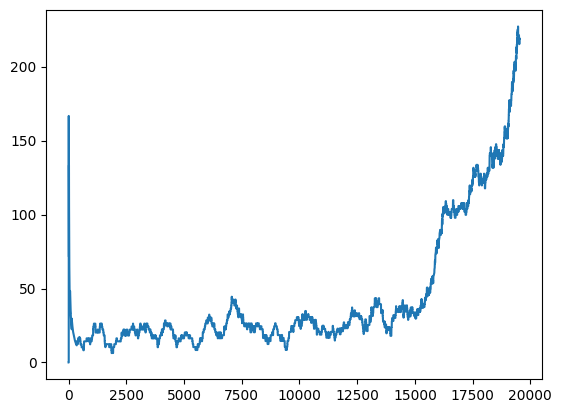

In [9]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)